In [64]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

import cv2
import numpy as np
import pandas as pd
import networkx as nx
import ogr
import time
from scipy.spatial import Voronoi, voronoi_plot_2d

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph

# Necessary for the cooked test data
from unittest.mock import Mock
from unittest.mock import MagicMock
from autocnet.graph import edge
from autocnet.graph import node
from plio.io import io_gdal

from autocnet.transformation.transformations import Homography
from autocnet.utils.utils import array_to_poly

from IPython.display import display

%pylab inline
figsize(20, 20)

Populating the interactive namespace from numpy and matplotlib


In [65]:
def scale_poly(point, centroid, scalar):
    point = np.asarray(point)
    centroid = centroid[:2]
    vector = ((point - centroid)*scalar) + centroid
    return (vector)

In [66]:
def reproj_point(H, point):
    """
    Reproject a pixel in one image into another image
    
    Parameters
    ----------
    H : object
        (3,3) ndarray or Homography object
        
    corner : iterable
             A 2 element iterable in the form x, y
    """
    if len(point) == 2:
        coords = np.array([point[0],point[1],1])
    elif len(point) == 3:
        coords = np.asarray(point)
        coords *= coords[-1]  # Homogenize
    
    return H.dot(coords)

In [67]:
def compute_intersection(graph, clean_keys=[]):
    source = graph.node[0]
    source_corners = source.geodata.xy_corners
    total_intersect_poly = array_to_poly(source_corners)
    orig_poly = array_to_poly(source_corners)
    
    # Method for displaying the images transformed using the homography, should be used in the visualiation
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.add_patch(Polygon(source_corners, facecolor='blue',alpha=0.25, edgecolor='k'))
    # End visualization section
    
    # Begin iterating through the nodes in the graph excluding the zero node
    for n in graph.nodes_iter():
        if n == 0:
            continue
        
        # Define the edge, matches, and destination based on the zero node and the nth node
        edge = graph.edge[0][n]
        matches, _ = edge.clean(clean_keys=clean_keys)
        destination = edge.destination
        destination_corners = destination.geodata.xy_corners
        
        kp1 = edge.source.get_keypoint_coordinates(index=matches['source_idx'], homogeneous=True)
        kp2 = edge.destination.get_keypoint_coordinates(index=matches['destination_idx'], homogeneous=True)
        
        # If the source image has coordinate transformation data, us the footprint and
        # coordinate transforms as it will produce a more accurate intersection
        if edge.source.geodata.coordinate_transformation.this != None:
            source_footprint_poly = edge.source.geodata.footprint
            destination_footprint_poly = edge.destination.geodata.footprint

            intersection_poly = destination_footprint_poly.Intersection(source_footprint_poly)
            intersection_points = intersection_poly.GetGeometryRef(0).GetPoints()
            intersection_points = [edge.source.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersect_points]

        # Else, use the homography transform to get an intersection of the two images
        else:
            H, mask = cv2.findHomography(kp2.values,
                                         kp1.values,
                                         cv2.RANSAC,
                                         2.0)

            proj_corners = []
            for c in destination_corners:
                x, y, h = reproj_point(H, c)
                x /= h
                y /= h
                h /= h
                proj_corners.append((x, y))

            proj_poly = array_to_poly(proj_corners)

            intersection_poly = orig_poly.Intersection(proj_poly)
            intersection_points = intersection_poly.GetGeometryRef(0).GetPoints()
            
        # Intersect the newly calculated intersection with the current total intersection
        # to get the new bound of the overlap area
        total_intersect_poly = intersection_poly.Intersection(total_intersect_poly)
        total_intersect_points = total_intersect_poly.GetGeometryRef(0).GetPoints()
            
        # Method for displaying the images transformed using the homography, should be used in the visualiation
        if (edge.source.geodata.coordinate_transformation.this == None):
            ax1.add_patch(Polygon(proj_corners, facecolor='red', alpha=0.25, edgecolor='k'))
        else:
            ax1.add_patch(Polygon(destination_corners, facecolor='red', alpha=0.25, edgecolor='k'))
            
    ax1.add_patch(Polygon(total_intersect_points, facecolor='green', alpha=0.25, edgecolor='k'))
        # End visualization section
        
    return total_intersect_poly

In [68]:
def vor(graph, clean_keys=[], s = 30, verbose = False):
    num_neighbors = len(graph.nodes()) - 1
    for n in graph.nodes():
        neighbors = len(graph.neighbors(n))
        if neighbors != num_neighbors:
            raise AssertionError('The graph is not complete')
    
    edge = graph.edge[0][1]
    matches, _ = edge.clean(clean_keys = ['fundamental'])
    kps = edge.source.get_keypoint_coordinates(index=matches['source_idx'], homogeneous=True)
    
    intersection_poly = compute_intersection(graph, clean_keys)
    intersection_points = intersection_poly.GetGeometryRef(0).GetPoints()
    
    centroid = intersection_poly.Centroid().GetPoint()
    
    points = np.asarray(kps)
    voronoi_np = []
    
    point_cloud = ogr.Geometry(ogr.wkbMultiPoint)
    for p in points:
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(double(p[0]), double(p[1]))
        point_cloud.AddGeometry(point)
    
    intersection_cloud = intersection_poly.Intersection(point_cloud)
    
    for p in intersection_cloud:
        point = p.GetPoint(0)
        voronoi_np.append(point)
    
    keypoints = np.asarray(voronoi_np)
    voronoi_pd = pd.DataFrame(data = voronoi_np, columns = ['x','y','homogenious'])
    
    # Based on the keypoints found in the method
    inters = np.empty((len(intersection_points),2))
    
    for g, (i, j) in enumerate(intersection_points):
        scaledx, scaledy = scale_poly((i, j), centroid, s)
        point = np.array([scaledx, scaledy])
        inters[g] = point
        
    keypoints = np.vstack((keypoints[:,:2], inters))
    vor = Voronoi(keypoints)
    
    voronoi_df = pd.DataFrame(columns=["x", "y", "weights"])
    voronoi_df["x"] = kps['x']
    voronoi_df["y"] = kps['y']
    matplotlib.pyplot.scatter(voronoi_pd['x'], voronoi_pd['y'], color = 'black')
    
    i = 0
    poly_array = []
    vor_points = np.asarray(vor.points)
    for region in vor.regions:
        region_point = vor_points[np.argwhere(vor.point_region==i)]
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            if len(polygon_points) != 0:
                polygon = array_to_poly(polygon_points)
                intersection = polygon.Intersection(intersection_poly)
                poly_array = np.append(poly_array, intersection)  # To see unclipped, replace intersection with polygon
                voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                               (voronoi_df["y"] == region_point[0][0][1]), 
                               'weights'] = intersection.GetArea()
        i+=1
        
    # Also for visualization of voronoi, adds the colored voronoi polygons to the image
    polygons = poly_array
    for i in polygons:
        geom = i.GetGeometryRef(0)
        if geom == None:
            continue
        else:
            points = geom.GetPoints()
            plt.fill(*zip(*points), alpha = .3)
    # End visualization section

Getting CT
CT <osgeo.osr.CoordinateTransformation; proxy of None >


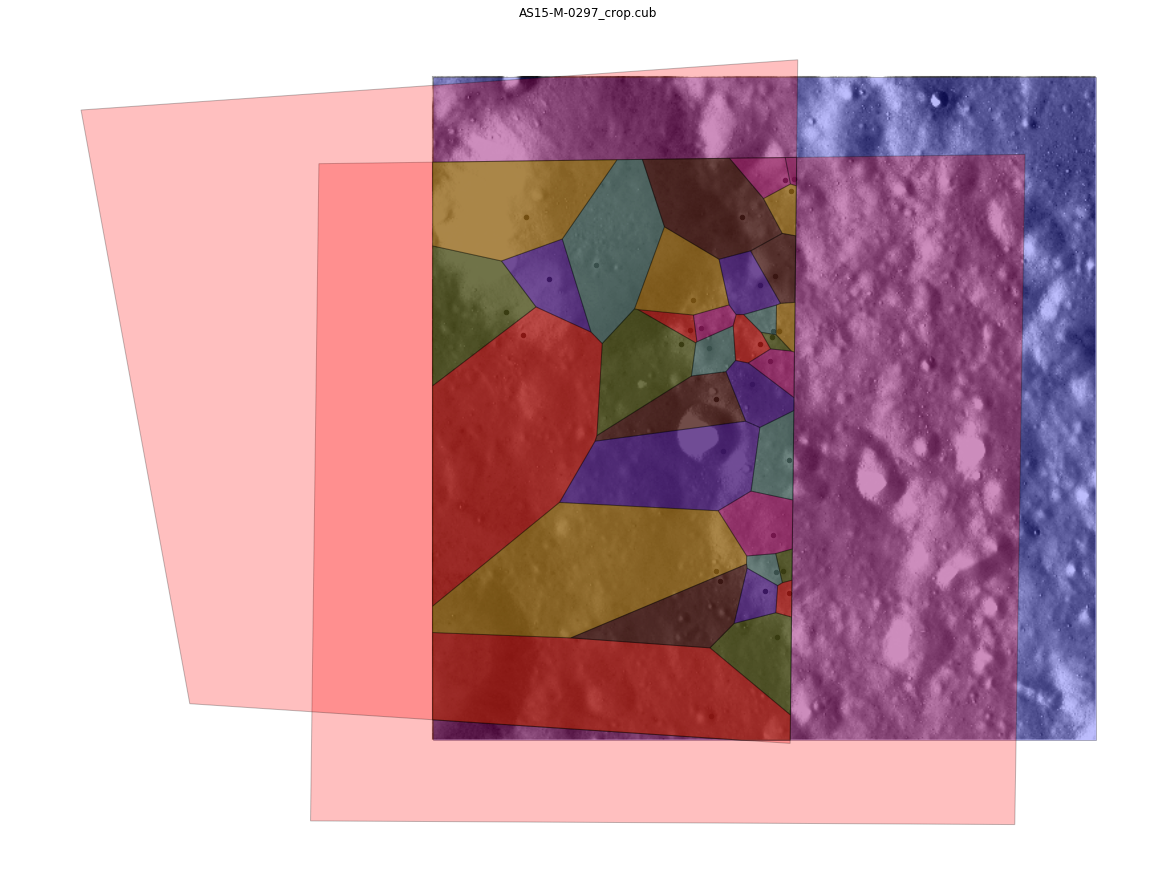

In [69]:
adjacency = get_path('cube_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':1000})

#Match
cg.match_features()

#Apply outlier detection
cg.symmetry_checks()
cg.ratio_checks()

#Compute a homography and apply RANSAC
cg.compute_fundamental_matrices(clean_keys=['ratio', 'symmetry'])

cg.compute_homographies(clean_keys = ['fundamental'], reproj_threshold = .5)

edge = cg.edge[0][1]
vor(cg, clean_keys=['fundamental'])
matches, mask = edge.clean(clean_keys = ['fundamental'])
edge.source.plot(index_mask = matches['source_idx'], color = 'black', s = 0, alpha = 0)
show()

In [70]:
def plot_cluster(graph, ax=None, cmap='Spectral'):
    if ax is None:
        ax = plt.gca()

    if not hasattr(graph, 'clusters'):
        raise AttributeError('Clusters have not been computed.')

    cmap = matplotlib.cm.get_cmap(cmap)

    colors = []

    for i, n in graph.nodes_iter(data=True):
        for j in graph.clusters:
            if i in graph.clusters.get(j):
                print(cmap(j))
                colors.append(cmap(j)[0])
                continue

    nx.draw(graph, ax=ax, node_color=colors)
    return ax

In [72]:
g = CandidateGraph.from_graph(get_path('sixty_four_apollo.graph'))
print(g.clusters)
subgraph = g.create_node_subgraph(g.clusters[10])
num_neighbors = len(subgraph.nodes()) - 1
print("Initial number of neighbors", num_neighbors)
for n in subgraph.nodes():
    neighbors = len(subgraph.neighbors(n))
    print("Number of neighbors for node",n, ":", neighbors)
    if neighbors != num_neighbors:
        continue
subgraph.compute_clusters()
# plot_cluster(g)
# subgraph.plot()

{0: [0, 5, 6, 24, 28, 29, 32, 34, 40, 47, 48, 51, 56], 1: [4, 41], 2: [7], 3: [8, 53], 4: [3, 10, 11, 25, 31], 5: [16], 6: [18], 7: [26], 8: [30, 63], 9: [12, 14, 22, 27, 37, 55], 10: [2, 15, 17, 20, 35, 39, 45, 54, 57, 61, 62], 11: [9, 43, 50], 12: [1, 13, 19, 23, 33, 36, 38, 42, 44, 46, 49, 58, 59, 60], 13: [21, 52]}
Initial number of neighbors 10
Number of neighbors for node 17 : 9
Number of neighbors for node 2 : 10
Number of neighbors for node 35 : 10
Number of neighbors for node 20 : 10
Number of neighbors for node 54 : 10
Number of neighbors for node 39 : 10
Number of neighbors for node 57 : 10
Number of neighbors for node 61 : 9
Number of neighbors for node 45 : 10
Number of neighbors for node 62 : 10
Number of neighbors for node 15 : 10
